Submission 3 Kelas Belajar Pengembangan Machine Learning <br>
<b>Image Classification Model Deployment</b> <br>
menggunakan dataset dari https://www.kaggle.com/pranavsingaraju/facemask-detection-dataset-20000-images <br>
<hr>
No. Registrasi: 0182180030-11 <br>
Nama: Dian Kurnia Imanda <br>
Email: diankurniaimanda@gmail.com

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!pip install -q keras
import keras

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import os

In [5]:
# melakukan ekstraksi pada file zip

!unzip /content/drive/MyDrive/face-mask.zip -d /content/drive/MyDrive/face-mask

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5000.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5001.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5002.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5003.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5004.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5005.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5006.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5007.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5008.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5009.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5010.png  
  inflating: /content/drive/MyDrive/face-mask/new_without_mask/seed5011.png  
  inflating: 

In [6]:
train_path = '/content/drive/MyDrive/face-mask'
os.listdir(train_path)

['new_with_mask', 'new_without_mask']

In [7]:
# add preprocessing layer to the front of vgg
vgg = VGG19(input_shape=(128,128,3), weights = 'imagenet', include_top = False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)), #input_shape, filters, kernel_size, activation
    tf.keras.layers.MaxPooling2D(2, 2), #pool_size,strides
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.applications.vgg19(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

In [9]:
class TestCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
            print('\nAkurasi mencapai 92%')
            self.model.stop_training=True
callbacks = TestCallback()

In [10]:
model.compile(loss='categorical_crossentropy', #sparse
              optimizer='adam', #adam, RMSProp
              metrics=['accuracy'])

In [11]:
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 20, #20
                    horizontal_flip = True,
                    vertical_flip = True,
                    shear_range = 0.2,
                    fill_mode = 'nearest', #wrap, nearest
                    validation_split = 0.2,
                    brightness_range = [0.2,1.0],
                    zoom_range= 0.2
                    #height_shift_range=0.5,
                    #width_shift_range=0.5
                    )
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.2)

In [12]:
train_generator = train_datagen.flow_from_directory(
        train_path,  # direktori data latih
        target_size=(128, 128),  # mengubah resolusi seluruh gambar menjadi 128x128 piksel
        batch_size=32, #4
        shuffle=True,
        class_mode='categorical', #sparse
        subset='training') 

validation_generator = test_datagen.flow_from_directory(
        train_path, # direktori data validasi
        target_size=(128, 128), # mengubah resolusi seluruh gambar menjadi 128x128 piksel
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
        subset='validation') #train_datagen test

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [13]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=20,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks= [callbacks])

Epoch 1/20
25/25 - 38s - loss: 0.7039 - accuracy: 0.4925 - val_loss: 0.6930 - val_accuracy: 0.4688
Epoch 2/20
25/25 - 37s - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6871 - val_accuracy: 0.5250
Epoch 3/20
25/25 - 37s - loss: 0.6629 - accuracy: 0.5750 - val_loss: 0.4934 - val_accuracy: 0.6125
Epoch 4/20
25/25 - 37s - loss: 0.3637 - accuracy: 0.8475 - val_loss: 0.0335 - val_accuracy: 0.9937
Epoch 5/20
25/25 - 37s - loss: 0.0960 - accuracy: 0.9750 - val_loss: 0.0433 - val_accuracy: 0.9875

Akurasi mencapai 92%


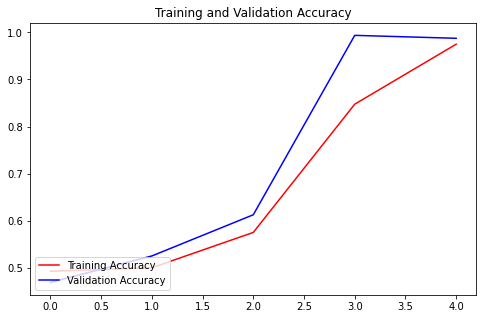

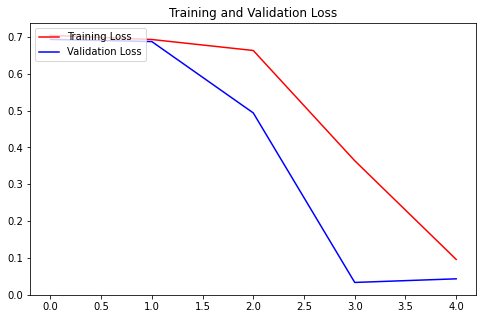

In [14]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy'] 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(8,5))
plt.plot(epochs_range, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss, 'r', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper left')
plt.show()

In [15]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# simpan model dalam format .tflite
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmptrzzgdzy/assets


In [16]:
# simpan model dg HDF5
model.save('mymodel.h5')